# Table of Contents

1. [Restructuring the JSON Data](#Restructuring-The-JSON-Data)
2. [Preprocessing](#Preprocessing-JSON-to-Tabular)
3. [Troubleshooting](#Troubleshooting.)
6.   [Random Forest Model to Predict LTV](#Random-Forest-Model-to-Predict-LTV)
7.    [Results from initial Random Forest](#Results-from-initial-Random-Forest)
8. [Results from Eval.Test Set](#Results-from-Evaluation-Test-Set)
9. [K-Fold Result](#K-Fold-Result)
10. [Results from Gradient Boosting](#Results-from-Gradient-Boosting)
12. [Results from Hyperparameter Tuning](#Results-from-Hyperparameter-Tuning)
13. [Results Summary Table](#Results-Summary-Table)
14. [Time Series Analysis](#Time-Series-Analysis)
15. [Time Series Results](#Time-Series-Results)




In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
df = pd.read_csv('Downloads/Result_1.csv')
print(df.head())

       created_at  \
0  10/29/24 21:27   
1  10/29/24 21:03   
2  10/29/24 19:56   
3  10/29/24 18:37   
4  10/29/24 16:44   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [211]:
df.shape

(516, 20)

In [213]:
df.describe

<bound method NDFrame.describe of          created_at  \
0    10/29/24 21:27   
1    10/29/24 21:03   
2    10/29/24 19:56   
3    10/29/24 18:37   
4    10/29/24 16:44   
5    10/29/24 15:34   
6    10/28/24 21:57   
7    10/28/24 19:43   
8    10/28/24 15:44   
9    10/28/24 15:44   
10   10/28/24 13:15   
11   10/26/24 15:44   
12   10/26/24 15:38   
13   10/26/24 15:33   
14   10/25/24 16:57   
15   10/25/24 16:23   
16   10/25/24 16:23   
17   10/25/24 16:10   
18   10/25/24 16:10   
19   10/25/24 10:31   
20   10/24/24 18:11   
21   10/24/24 15:20   
22   10/23/24 13:38   
23   10/22/24 21:16   
24   10/22/24 20:42   
25   10/22/24 19:11   
26   10/22/24 19:11   
27   10/22/24 18:06   
28   10/22/24 18:06   
29   10/22/24 16:37   
30   10/22/24 15:25   
31   10/22/24 15:25   
32   10/22/24 15:17   
33   10/22/24 13:57   
34   10/21/24 21:12   
35   10/21/24 15:52   
36   10/21/24 14:06   
37   10/20/24 20:58   
38   10/18/24 21:10   
39   10/18/24 16:11   
40   10/17/24 18:28   


In [215]:
df.columns

Index(['created_at', 'filtered_json', 'CreatedDate', 'Carrier', 'vrna_policy_type_c', 'vrna_effective_date_c', 'vrna_expiration_date_c', 'vrna_initial_premium_amount_c', 'vrna_status_c', 'Term', 'Month_Premium', 'Multi_Ind', 'LTV_Rate', 'Mono_LTMonths', 'LTV_Months', 'Est_LTV', 'ReferralSource', 'State', 'LongCode', 'rn'], dtype='object')

In [217]:
# Viewing Entire JSON String


filtered_json_column = df['filtered_json']
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

# Display the entire 'filtered_json' column
print(filtered_json_column)

0                                                                                                                                                                                                                                                             {"policy": {"address": {"zip": null, "city": null, "plus4": null, "state": null, "county": null}, "coverages": null, "coverageTier": null, "eSignDocument": null, "effectiveDate": null, "expirationDate": null, "isValidAddress": null, "acceptUpdatedPrice": null}, "vehicles": [{"id": "1", "make": "honda", "trim": "TOURING", "year": "2020", "model": "pilot", "coverages": "{\"tort\": \"\", \"rental\": \"\", \"towing\": \"\", \"medical\": \"\", \"collision\": \"\", \"pipMedical\": \"\", \"bodilyInjury\": \"\", \"comprehensive\": \"\", \"pipDeductible\": \"\", \"pipIncomeLoss\": \"\", \"propertyDamage\": \"\", \"uninsuredMotorist\": \"\", \"pipAccidentalDeath\": \"\", \"underInsuredMotorist\": \"\", \"customPartsAndEquipment\": \"\", \"persona

## Restructuring The JSON Data

The Policy holder info was imputed into a columns named 'filtered_json' it's done with nested JSON strings, empty inputs and null values. The below will be the extraction, cleaning and converting to a tabular data set. 

**There should be 5 main strings and nested strings within them**

1. **'policy'**: {'address': {'zip': None, 'city': None, 'plus4': None, 'state': None, 'county': None}, 
'coverages': None, 'coverageTier': None, 'eSignDocument': None, 'effectiveDate': None, 'expirationDate': None, 'isValidAddress': None, 'acceptUpdatedPrice': None},

2. **'vehicles'**: [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot',

**'coverages’**: '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}], 

3. **'discounts'**: {'paperless': True, 'payInFull': True, 'goodStudent': False, 'ubiEnrollment': True, 'defensiveDriver': True, 'rightTrackProgram': {'enroll': '', 'phoneNumber': ''},
4. **'multiPolicyDiscount'**: {'home': False, 'life': False, 'condo': False, 'renter': False, 'landlord': False, 'property': False, 'umbrella': False, 'motorcycle': False, 'watercraft': False, 'recreationalVehicle': False}, 'hasNonAutoCarrierPolicy': ''},
5. **'operators'**: [{'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male',
 'carrier': 'Allstate', 
'education': "Bachelor's Degree", 

'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 

'isPrimary': 'true', 
'occupation': 'Manager/Supervisor', 
'creditScore': 'Excellent (750+)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Own', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': '3-4 years', 'yearsContinuouslyInsured': ''}]}







In [220]:
df.head(1)

created_at  \
0  10/29/24 21:27   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          filtered_json  \
0  {"policy": {"address": {"zip": null, "city": null, "plus4": null, "state": null, "county": null}, "coverages": null, "coverageTier": null, "eSignDocument": null, "effectiveDate": null, "expirationDate": null, "isValidAddress": null, "acceptUpdatedPrice": null}, "vehicles": [{"id": "1", "make": "honda", "trim": "TOURING", "year": "2020", "model": "pilot", "coverages": "{\"tort\": \"\", \"rental\": \"\", \"towing\": \"\", \"medical\": \"\", \"collision\": \"\", \"pipMedical\": \"\", \"bodilyInjury\": \"\", \"comprehensive\": \"\", \"pipDeductible\": \"\", \"pipIncomeLoss\": \"\", \"propertyDamage\": \"\", \"uninsuredMotorist\": \"\", \"pipAccidentalDeath\": \"\", \"underInsuredMotorist\": \"\", \"customPartsAndEquipment\": \"\", \"personalInjuryProtection\": \"\", \"uninsuredMotoristPropertyDamage\": \"\"}", "partialVin": "5FNYF5H60LB000000", "primaryUse": "Commute", "fullCoverage": "Yes", "annualMileage": "3650", "ownershipStatus": "Own", "rideShareCoverage": "false"}], "discounts": {"paperless": true, "payInFull": true, "goodStudent": false, "ubiEnrollment": true, "defensiveDriver": true, "rightTrackProgram": {"enroll": "", "phoneNumber": ""}, "multiPolicyDiscount": {"home": false, "life": false, "condo": false, "renter": false, "landlord": false, "property": false, "umbrella": false, "motorcycle": false, "watercraft": false, "recreationalVehicle": false}, "hasNonAutoCarrierPolicy": ""}, "operators": [{"id": "1", "age": 44, "sr22": {"filingDate": "", "isRequired": "No", "filingEndDate": "", "filingCaseNumber": ""}, "gender": "Male", "carrier": "Allstate", "education": "Bachelor's Degree", "incidents": "{\"hasDui\": \"No\", \"accidents\": [], \"violations\": [], \"ticketNumber\": \"0\", \"hasAtFaultAccident\": \"0\", \"isDriversLicenseSuspended\

In [222]:
import json

filtered_json_dict = df['filtered_json'].apply(lambda x: json.loads(x) if isinstance(x, str) else {})

flattened_json_data = pd.json_normalize(filtered_json_dict, sep='_')

df = pd.concat([df.drop(columns=['filtered_json']).reset_index(drop=True), flattened_json_data.reset_index(drop=True)], axis=1)


In [224]:
df.head()

created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1   [{'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1FM5K7DH0LG000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '18250', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '7500', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
3  10/29/24 18:37    10/29/24  Dairyland       Personal Auto              10/29/24                4/29/25                         546.28           New   6.0          91.05        NaN     0.090            12         12    98.33  BR Auto Results Page   

In [226]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  

df.sample(1)

created_at CreatedDate      Carrier vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                        LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  vehicles  \
158  9/25/24 18:21     9/25/24  Progressive         Motorcycle               9/25/24                9/25/25                         330.76           New  12.0          27.56        1.0      0.09            36         60   148.82  BR Auto Results Page   NaN  ProgressiveMotorcycle987278244   1  [{'id': '1', 'make': 'volvo', 'trim': 'T5', 'year': '2008', 'model': 'c30', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': 'YV1MK672082000000', 'primaryUse': 'Commute', 'fullCoverage': 'No', 'annualMileage': '4000', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   operators policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress  \
158  [{'id': '1', 'age': 34, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male', 'carrier': 'AAA/Auto Club', 'education': 'High School Diploma', 'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 'isPrimary': 'true', 'occupation': 'Skilled/Semi-skilled', 'creditScore': 'Good (700-749)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Rent', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': '3-4 years', 'yearsContinuouslyInsured': ''}]               None                None                 None                 None                  None             None                None                 None                 None                  None                  None   

    policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rig

### Preprocessing JSON to Tabular

Needing to convert JSON to tabular in
- vheciles
- operators
- discounts

Then concatenate the new df files in with the original df. 

In [231]:
flattened_json_data.head()

vehicles  \
0  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
1   [{'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1FM5K7DH0LG000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '18250', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
2  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '7500', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
3         [{'id': '1', 'make': 'dodge', 'trim': 'SLT', 'year': '2002', 'model': 'dakota', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '1B7FL46N02S000000', 'primaryUse': 'Other', 'fullCoverage': 'No', 'annualMileage': '730', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   
4   [{'id': '1', 'make': 'hyundai', 'trim': 'SE', 'year': '2016', 'model': 'elantra', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5NPDH4AD0GH000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '6205', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 operators polic

In [233]:
import json

# Check if a sample row from a column contains JSON
try:
    sample_data = json.loads(df['vehicles'].iloc[0])
    print("Column 'vehicles' contains JSON data.")
except (json.JSONDecodeError, TypeError):
    print("Column 'vehicles' does not contain JSON data.")

Column 'vehicles' does not contain JSON data.


In [235]:
df['vehicles']

0                            [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]
1                             [{'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsure

## Troubleshooting. 

'vehciles' and 'operators' data didn't get included in the df_cleaned below. I believe it was b/c I tried to do them all int he same code block. I'll try again sequentially and integrate them into df_cleaned individually. 

### Cont. 

I tried to flatten individually and found that the flatten is failing silently. I tried flattening the 'vehicles' tab first and it removed the JSON strings and the 'vehicles' column but didn't add the new columns into the new df. 

### Cont. 

After checking the output of json.loads it looks like it wasn't parsing the data correctly. Then I ran  .dtype and it was 'object' but when I ran .iloc to inspect the column further it showed that it wasn't JSON data I was looking at but a list of dictionaries rather than a JSON string (eyeroll). 

In [240]:
# extracting 'operators' dictionary

operators_dict = df['operators'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
print(operators_dict.head())  # Check the resulting dictionary-like structures

0            {'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male', 'carrier': 'Allstate', 'education': 'Bachelor's Degree', 'incidents': '{"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}', 'isPrimary': 'true', 'occupation': 'Manager/Supervisor', 'creditScore': 'Excellent (750+)', 'licenseState': '', 'relationship': 'Self', 'timeEmployed': '', 'maritalStatus': 'No', 'licenseObtainedAge': '', 'homeOwnershipStatus': 'Own', 'isExperiencedDriver': '', 'militaryAffiliation': 'No', 'hasCancelledInsurance': '', 'yearsWithCurrentCarrier': '3-4 years', 'yearsContinuouslyInsured': ''}
1            {'id': '1', 'age': 44, 'sr22': {'filingDate': '', 'isRequired': 'No', 'filingEndDate': '', 'filingCaseNumber': ''}, 'gender': 'Male', 'carrier': 'Allstate', 'education': 'Bachelor's Degree', 'incidents': '{"hasDui": "No", "accidents": [], "

In [242]:
#Now flattening the new operators dtci

operators_dict = pd.json_normalize(operators_dict)
print(operators_dict.head())  

  id   age  gender         carrier          education                                                                                                                               incidents isPrimary          occupation        creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus isExperiencedDriver militaryAffiliation hasCancelledInsurance yearsWithCurrentCarrier yearsContinuouslyInsured sr22.filingDate sr22.isRequired sr22.filingEndDate sr22.filingCaseNumber  sr22
0  1  44.0    Male        Allstate  Bachelor's Degree  {"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}      true  Manager/Supervisor   Excellent (750+)                      Self                         No                                    Own                                      No                                     3-4 years                                                       No      

In [244]:
# now I'll add the flattened operators data back into the original df

df_cleaned = pd.concat([df.drop(columns=['operators']).reset_index(drop=True), operators_dict.reset_index(drop=True)], axis=1)

df_cleaned.head(1)

created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:27     11/9/23     NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN        Website    MA      NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]               None                None                 None                 None   

  policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age gender   carrier          education                                                                                                                               incidents isPrimary  \
0                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False                                    False                                    False                                             False                                          NaN  1  44.0   Male  Allstate  Bachelor's Degree  {"hasDui": "No", "accidents": [], "violations": [], "ticketNumber": "0", "hasAtFaultAccident": "0", "isDriversLicenseSuspended": "No"}      true   

           occupation       creditScore licenseState re

In [246]:
# now to extract indicents


# Flatten the `incidents` column
incidents_dict = df_cleaned['incidents'].apply(lambda x: json.loads(x) if isinstance(x, str) else None)
incidents_data = pd.json_normalize(incidents_dict)

# Drop the original `incidents` column from `df_cleaned`
df_cleaned = df_cleaned.drop(columns=['incidents'])

# Concatenate `incidents_data` with the main DataFrame
df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), incidents_data.reset_index(drop=True)], axis=1)

print(df_cleaned.head(1))



       created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:2

In [248]:
df_cleaned.head(1)

created_at CreatedDate Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV ReferralSource State LongCode  rn                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          vehicles policy_address_zip policy_address_city policy_address_plus4 policy_address_state  \
0  10/29/24 21:27     11/9/23     NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN        Website    MA      NaN   1  [{'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}]               None                None                 None                 None   

  policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age gender   carrier          education isPrimary          occupation       creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus  \
0                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False                                    False                                    False                                             False                                          NaN  1  44.0   Male  Allstate  Bachelor's Degree      true  Manager/Supervisor  Excellent (750+)                      Self                         No                                    Own   

  isExperiencedDriver militaryAffiliation hasCancelledInsurance yea

In [250]:

vehicles_dict = df['vehicles'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

print(vehicles_dict.head())  


0    {'id': '1', 'make': 'honda', 'trim': 'TOURING', 'year': '2020', 'model': 'pilot', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underInsuredMotorist": "", "customPartsAndEquipment": "", "personalInjuryProtection": "", "uninsuredMotoristPropertyDamage": ""}', 'partialVin': '5FNYF5H60LB000000', 'primaryUse': 'Commute', 'fullCoverage': 'Yes', 'annualMileage': '3650', 'ownershipStatus': 'Own', 'rideShareCoverage': 'false'}
1     {'id': '1', 'make': 'ford', 'trim': 'XLT', 'year': '2020', 'model': 'explorer', 'coverages': '{"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeductible": "", "pipIncomeLoss": "", "propertyDamage": "", "uninsuredMotorist": "", "pipAccidentalDeath": "", "underIns

In [252]:
vehicles_data = pd.json_normalize(vehicles_dict)

In [254]:

df_cleaned = df_cleaned.drop(columns=['vehicles'])

df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), vehicles_data.reset_index(drop=True)], axis=1)

print(df_cleaned.head())

       created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  1

In [256]:
df_cleaned.sample(1)

created_at CreatedDate            Carrier vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                               LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property  \
296  8/29/24 15:24     7/30/24  Assurance America         Homeowners               7/30/24                    NaN                            NaN           New   NaN            NaN        1.0      0.11            24         40      NaN  BR Auto Results Page   NaN  Assurance AmericaHomeowners0011038302   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                   False                     False                                                                                                         False                              False                               False                                False                                  False                                  False   

    discounts_multiPolicyDiscount_umbrella discounts_multiPolicyDiscount_motorcycle discounts_multiPolicyDiscount_watercraft discounts_multiPolicyDiscount_recreationalVehicle discounts_hasNonAutoCarrierPolicy  discounts id   age  gender  carrier            education isPrimary           occupation     creditScore licenseState relationship timeEmployed maritalStatus licenseObtainedAge homeOwnershipStatus isExperiencedDriver militaryAffiliation hasCancelledInsurance yearsWithCurrentCarrier yearsContinuouslyInsured sr22.filingDate sr22.isRequired sr22.filingEndDate sr22.filingCaseNumber  sr22 hasDui accidents violations ticketNumber hasAtFaultAccident isDriversLicenseSuspended id      make     trim  year     model  \
296                                  False                                    False                                    False                                             False                                          NaN  1  38.0  Female  Farmers  High School Diploma      true  Construction Trades  Good (700-749)                      Self                         No                                    Own                                      No                                     1-2 years                                                       No                                            NaN     No        []         []            0                  0                        No  1  chrysler  LIMITED  2020  pacifica   

                                                                                                                                                                                                                                                                                                                                                                                    coverages         partialVin primaryUse fullCoverage annualMileage ownershipStatus rideShareCoverage  
296  {"tort": "", "rental": "", "towing": "", "medical": "", "collision": "", "pipMedical": "", "bodilyInjury": "", "comprehensive": "", "pipDeduct

In [258]:
coverages_dict = df_cleaned['coverages'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else {})

coverages_data = pd.json_normalize(coverages_dict)

df_cleaned = df_cleaned.drop(columns=['coverages'])

df_cleaned = pd.concat([df_cleaned.reset_index(drop=True), coverages_data.reset_index(drop=True)], axis=1)

df_cleaned.head()


created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3  10/29/24 18:37    10

In [260]:
# Data is showing up misaligned

print(f"Original DataFrame Rows: {len(df)}")
print(f"Vehicles Data Rows: {len(vehicles_data)}")
print(f"Operators Data Rows: {len(operators_data)}")
print(f"Discounts Data Rows: {len(discounts_data)}")


Original DataFrame Rows: 516
Vehicles Data Rows: 516


NameError: name 'operators_data' is not defined

In [262]:
df_cleaned.head()

# actually it looks like they were always aligned. I just forgot to include the parentheses. 

created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0  10/29/24 21:27     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1  10/29/24 21:03     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2  10/29/24 19:56     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3  10/29/24 18:37    10

In [432]:
df_cleaned

CreatedDate            Carrier  vrna_policy_type_c vrna_effective_date_c vrna_status_c  LTV_Rate  Mono_LTMonths  LTV_Months         ReferralSource   age   gender           carrier                education isPrimary                   occupation creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended           make                         trim     year                model primaryUse fullCoverage  annualMileage ownershipStatus  TimePeriod_Morning  TimePeriod_Night
0       11/9/23            unknown  Commercial Package              11/10/23       Expired    0.0900           36.0        36.0                Website  44.0     Male          Allstate        Bachelor's Degree      true           Manager/Supervisor   Excellent         Self            No                 Own                  No               3-4 years     No                  0                        No          honda                      TOURING     2020                pilot    Commute          Yes         3650.0             Own               False              True
1       11/9/23            unknown  Commercial Package              11/10/23       Expired    0.0900           36.0        36.0                Website  44.0     Male          Allstate        Bachelor's Degree      true           Manager/Supervisor   Excellent         Self            No                 Own                  No               3-4 years     No                  0                        No           ford                          XLT     2020             explorer    Commute          Yes        18250.0             Own               False              True
2       11/9/23            unknown  Commercial Package              11/10/23       Expired    0.0900           36.0        36.0                Website  44.0     Male    Liberty Mutual        Bachelor's Degree      true           Manager/Supervisor   Excellent         Self           Yes                 Own                 Yes               3-4 years     No                  0                        No          honda                      TOURING     2020                pilot    Commute          Yes         7500.0             Own               False              True
3      10/29/24          Dairyland       Personal Auto              10/29/24           New    0.0900           12.0        12.0   BR Auto Results Page  47.0   Female              None         Some High School      true                     Disabled  Needs work         Self            No    Live with family                 Yes                    None     No                  0                        No          dodge                          SLT     2002               dakota      Other           No          730.0             Own               False              True
4      10/29/24           Lemonade          Homeowners              10/30/24           New    0.1250           36.0        60.0   BR Auto Results Page  28.0     Male              None        Bachelor's Degree      true               School Teacher   Excellent         Self            No                Rent                  No                    None     No                  0                        No        hyundai                           SE     2016              elantra    Commute          Yes         6205.0             Own               False             False
5      10/29/24   National General       Personal Auto               11/8/24           New    0.0900           24.0        24.0                unknown  47.0     Male       Progressive      High School Diploma      true         Skilled/Semi-skilled   Excellent         Self           Yes                 Own                  No        Less than a year     No                  0                        No          honda                           LX     2012                civic   Pleasure           No         7500.0             Own               False             False
6       11/9/2

### Checkpoint Preprocessing: JSON removed and Updated Df

Next:
- check for null values
- remove unnecessary columns

In [265]:
print(df_cleaned.isnull().sum())

created_at                                             0
CreatedDate                                            0
Carrier                                               39
vrna_policy_type_c                                     0
vrna_effective_date_c                                  0
vrna_expiration_date_c                               194
vrna_initial_premium_amount_c                        235
vrna_status_c                                          0
Term                                                 194
Month_Premium                                        237
Multi_Ind                                            298
LTV_Rate                                              39
Mono_LTMonths                                         39
LTV_Months                                            40
Est_LTV                                              237
ReferralSource                                         7
State                                                230
LongCode                       

In [267]:
df_cleaned.shape

(516, 91)

In [269]:
df_cleaned["LongCode"]
# Bailey said this was likley just a identifier from the coverage team. Removing

0                                            NaN
1                                            NaN
2                                            NaN
3              DairylandPersonal Auto11409827387
4                  LemonadeHomeownersLP25C86DE06
5        National GeneralPersonal Auto2025533588
6                                            NaN
7      National GeneralPersonal Auto202551741200
8              ProgressivePersonal Auto971111111
9          Assurance AmericaHomeowners0011038302
10             DairylandPersonal Auto11409827387
11         Bristol WestPersonal AutoG01537202600
12         Bristol WestPersonal AutoG01537202600
13         Bristol WestPersonal AutoG01537202600
14     National GeneralPersonal Auto202548331100
15             ProgressivePersonal Auto971111111
16         Assurance AmericaHomeowners0011038302
17             ProgressivePersonal Auto971111111
18         Assurance AmericaHomeowners0011038302
19       National GeneralPersonal Auto2025533588
20     National Gene

In [271]:
df_cleaned["Multi_Ind"]

# Can remove

0      NaN
1      NaN
2      NaN
3      NaN
4      1.0
5      NaN
6      NaN
7      NaN
8      1.0
9      1.0
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     1.0
16     1.0
17     1.0
18     1.0
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
30     1.0
31     1.0
32     NaN
33     NaN
34     NaN
35     NaN
36     NaN
37     1.0
38     NaN
39     NaN
40     NaN
41     1.0
42     1.0
43     NaN
44     NaN
45     NaN
46     1.0
47     1.0
48     NaN
49     NaN
50     NaN
51     NaN
52     NaN
53     NaN
54     1.0
55     1.0
56     NaN
57     NaN
58     1.0
59     1.0
60     NaN
61     NaN
62     NaN
63     NaN
64     NaN
65     NaN
66     NaN
67     NaN
68     NaN
69     NaN
70     NaN
71     1.0
72     1.0
73     NaN
74     NaN
75     NaN
76     1.0
77     1.0
78     1.0
79     1.0
80     NaN
81     1.0
82     1.0
83     NaN
84     NaN
85     NaN
86     NaN
87     NaN
88     NaN
89     NaN
90     1.0

In [273]:
df_cleaned["LTV_Rate"] #replace NaN with Median values are close enough together

0           NaN
1           NaN
2           NaN
3        0.0900
4        0.1250
5        0.0900
6           NaN
7        0.0900
8        0.0900
9        0.1100
10       0.0900
11       0.0800
12       0.0800
13       0.0800
14       0.0900
15       0.0900
16       0.1100
17       0.0900
18       0.1100
19       0.0900
20       0.0900
21       0.0800
22       0.0900
23       0.0800
24       0.0800
25       0.0900
26       0.1100
27       0.0900
28       0.1100
29       0.0900
30       0.0900
31       0.1100
32       0.0800
33       0.0900
34       0.0900
35       0.1150
36       0.1100
37       0.0900
38          NaN
39       0.1150
40       0.1150
41       0.0900
42       0.1100
43       0.0900
44       0.0900
45       0.0900
46       0.0900
47       0.1100
48       0.0900
49       0.1000
50       0.0900
51          NaN
52       0.0900
53       0.1000
54       0.0900
55       0.1100
56       0.0800
57       0.0900
58       0.0900
59       0.1100
60          NaN
61       0.0900
62      

In [275]:
df_cleaned["created_at"] #needs date and time separated? 

0      10/29/24 21:27
1      10/29/24 21:03
2      10/29/24 19:56
3      10/29/24 18:37
4      10/29/24 16:44
5      10/29/24 15:34
6      10/28/24 21:57
7      10/28/24 19:43
8      10/28/24 15:44
9      10/28/24 15:44
10     10/28/24 13:15
11     10/26/24 15:44
12     10/26/24 15:38
13     10/26/24 15:33
14     10/25/24 16:57
15     10/25/24 16:23
16     10/25/24 16:23
17     10/25/24 16:10
18     10/25/24 16:10
19     10/25/24 10:31
20     10/24/24 18:11
21     10/24/24 15:20
22     10/23/24 13:38
23     10/22/24 21:16
24     10/22/24 20:42
25     10/22/24 19:11
26     10/22/24 19:11
27     10/22/24 18:06
28     10/22/24 18:06
29     10/22/24 16:37
30     10/22/24 15:25
31     10/22/24 15:25
32     10/22/24 15:17
33     10/22/24 13:57
34     10/21/24 21:12
35     10/21/24 15:52
36     10/21/24 14:06
37     10/20/24 20:58
38     10/18/24 21:10
39     10/18/24 16:11
40     10/17/24 18:28
41     10/16/24 20:13
42     10/16/24 20:13
43     10/16/24 20:04
44     10/16/24 19:42
45     10/

In [277]:
# Convert 'created_at' column to datetime type
df_cleaned['created_at'] = pd.to_datetime(df_cleaned['created_at'], format='%m/%d/%y %H:%M')

# separate columns for 'date' and 'time'
df_cleaned['date'] = df_cleaned['created_at'].dt.date
df_cleaned['time'] = df_cleaned['created_at'].dt.time

df_cleaned.head()

created_at CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_expiration_date_c  vrna_initial_premium_amount_c vrna_status_c  Term  Month_Premium  Multi_Ind  LTV_Rate Mono_LTMonths LTV_Months  Est_LTV        ReferralSource State                           LongCode  rn policy_address_zip policy_address_city policy_address_plus4 policy_address_state policy_address_county policy_coverages policy_coverageTier policy_eSignDocument policy_effectiveDate policy_expirationDate policy_isValidAddress policy_acceptUpdatedPrice discounts_paperless discounts_payInFull discounts_goodStudent discounts_ubiEnrollment discounts_defensiveDriver discounts_rightTrackProgram_enroll discounts_rightTrackProgram_phoneNumber discounts_multiPolicyDiscount_home discounts_multiPolicyDiscount_life discounts_multiPolicyDiscount_condo discounts_multiPolicyDiscount_renter discounts_multiPolicyDiscount_landlord discounts_multiPolicyDiscount_property discounts_multiPolicyDiscount_umbrella  \
0 2024-10-29 21:27:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
1 2024-10-29 21:03:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
2 2024-10-29 19:56:00     11/9/23        NaN  Commercial Package              11/10/23                11/9/24                            NaN       Expired  11.0            NaN        NaN       NaN           NaN        NaN      NaN               Website    MA                                NaN   1               None                None                 None                 None                  None             None                None                 None                 None                  None                  None                      None                True                True                 False                    True                      True                                                                                                         False                              False                               False                                False                                  False                                  False                                  False   
3 2024-10-2

In [279]:
df_cleaned.shape #checking that all columns are still there. Should now be 93

(516, 93)

## Checkpoint Preprocessing: Column Removal

Finding additional columns that need to be removed that are only ordinal information, identifiers only unique to the platform they were housed in and data that isn't variable in determining LTV. 

In [282]:
# List of columns to remove
columns_to_remove = [
     'discounts_paperless',
    'discounts_payInFull',
    'discounts_goodStudent',
    'discounts_ubiEnrollment',
    'discounts_defensiveDriver',
    'discounts_rightTrackProgram_enroll',
    'discounts_rightTrackProgram_phoneNumber',
    'discounts_multiPolicyDiscount_home',
    'discounts_multiPolicyDiscount_life',
    'discounts_multiPolicyDiscount_condo',
    'discounts_multiPolicyDiscount_renter',
    'discounts_multiPolicyDiscount_landlord',
    'discounts_multiPolicyDiscount_property',
    'discounts_multiPolicyDiscount_umbrella',
    'discounts_multiPolicyDiscount_motorcycle',
    'discounts_multiPolicyDiscount_watercraft',
    'discounts_multiPolicyDiscount_recreationalVehicle',
    'discounts_hasNonAutoCarrierPolicy',
    'policy_address_zip', 
    'policy_address_city', 
    'policy_address_plus4', 
    'policy_address_state',
    'policy_address_county', 
    'policy_coverages', 
    'policy_coverageTier', 
    'policy_eSignDocument',
    'policy_effectiveDate', 
    'policy_expirationDate', 
    'policy_isValidAddress', 
    'policy_acceptUpdatedPrice', 
    'discounts', 
    'sr22',
    'Multi_Ind', 
    'LongCode', 
    'Est_LTV',
    'licenseState', 
    'timeEmployed', 
    'licenseObtainedAge', 
    'isExperiencedDriver',
    'hasCancelledInsurance', 
    'yearsContinuouslyInsured', 
    'sr22.filingDate',
    'sr22.filingEndDate','sr22.filingCaseNumber','sr22.isRequired',
    'filingCaseNumber', 
    'id', 
    'tort', 
    'rental', 
    'towing',
    'medical', 
    'collision', 
    'pipMedical', 
    'bodilyInjury', 
    'comprehensive',
    'pipIncomeLoss', 
    'pipDeductible', 
    'propertyDamage', 
    'uninsuredMotorist',
    'pipAccidentalDeath', 
    'underInsuredMotorist', 
    'customPartsAndEquipment',
    'personalInjuryProtection', 
    'uninsuredMotoristPropertyDamage','rideShareCoverage','rn', 'vrna_initial_premium_amount_c','Month_Premium','Term','State','vrna_expiration_date_c',
    'ticketNumber','accidents','created_at','date','violations','partialVin'
]

# Drop only the columns that are present in the DataFrame
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_remove if col in df_cleaned.columns])

# Display the updated DataFrame to verify
df_cleaned.head()


CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_status_c  LTV_Rate Mono_LTMonths LTV_Months        ReferralSource   age  gender         carrier          education isPrimary          occupation        creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended     make     trim  year     model primaryUse fullCoverage annualMileage ownershipStatus      time
0     11/9/23        NaN  Commercial Package              11/10/23       Expired       NaN           NaN        NaN               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes          3650             Own  21:27:00
1     11/9/23        NaN  Commercial Package              11/10/23       Expired       NaN           NaN        NaN               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No     ford      XLT  2020  explorer    Commute          Yes         18250             Own  21:03:00
2     11/9/23        NaN  Commercial Package              11/10/23       Expired       NaN           NaN        NaN               Website  44.0    Male  Liberty Mutual  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self           Yes                 Own                 Yes               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes          7500             Own  19:56:00
3    10/29/24  Dairyland       Personal Auto              10/29/24           New     0.090            12         12  BR Auto Results Page  47.0  Female            None   Some High School      true            Disabled  Needs work (<640)         Self            No    Live with family                 Yes                    None     No                  0                        No    dodge      SLT  2002    dakota      Other           No           730             Own  18:37:00
4    10/29/24   Lemonade          Homeowners              10/30/24           New     0.125            36         60  BR Auto Results Page  28.0    Male            None  Bachelor's Degree      true      School Teacher   Excellent (750+)         Self            No                Rent                  No                    None     No                  0                        No  hyundai       SE  2016   elantra    Commute          Yes          6205             Own  16:44:00

In [284]:
# Replace NaN values in df_cleaned based on the specified inputs

columns_to_convert = ['LTV_Rate', 'Mono_LTMonths', 'LTV_Months', 'age', 'annualMileage']

for column in columns_to_convert:
    df_cleaned[column] = df_cleaned[column].replace(['FLAT', 'NaN'], np.nan)  # Replace 'FLAT' and 'NaN' strings with np.nan
    df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')   # Convert to numeric, coercing errors to NaN

replacement_values = {
    'Carrier': 'unknown',
    'LTV_Rate': df_cleaned['LTV_Rate'].median(),
    'Mono_LTMonths': df_cleaned['Mono_LTMonths'].median(),
    'LTV_Months': df_cleaned['LTV_Months'].median(),
    'ReferralSource': 'unknown',
    'age': df_cleaned['age'].median(),
    'gender': 'unknown',
    'carrier': 'unknown',
    'education': 'unknown',
    'isPrimary': 'unknown',
    'occupation': 'unknown',
    'creditScore': 'unknown',
    'relationship': 'unknown',
    'maritalStatus': 'unknown',
    'homeOwnershipStatus': 'unknown',
    'militaryAffiliation': 'unknown',
    'yearsWithCurrentCarrier': 'unknown',
    'hasDui': 0,
    'accidents': 0,
    'violations': 0,
    'hasAtFaultAccident': 0,
    'isDriversLicenseSuspended': 0,
    'make': 'unknown',
    'trim': 'unknown',
    'year': 'unknown',
    'model': 'unknown',
    'primaryUse': 'unknown',
    'fullCoverage': 'unknown',
    'annualMileage': df_cleaned['annualMileage'].median(),
    'ownershipStatus': 'unknown'
}

# Replace NaN values in the specified columns
df_cleaned.fillna(value=replacement_values, inplace=True)


In [286]:
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], format='%H:%M:%S')

def assign_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Midday'
    else:
        return 'Night'

df_cleaned['TimePeriod'] = df_cleaned['time'].dt.hour.apply(assign_time_period)

df_cleaned = pd.get_dummies(df_cleaned, columns=['TimePeriod'], drop_first=True)

df_cleaned = df_cleaned.drop(columns=['time'])

df_cleaned.head()


CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_status_c  LTV_Rate  Mono_LTMonths  LTV_Months        ReferralSource   age  gender         carrier          education isPrimary          occupation        creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended     make     trim  year     model primaryUse fullCoverage  annualMileage ownershipStatus  TimePeriod_Morning  TimePeriod_Night
0     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes         3650.0             Own               False              True
1     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self            No                 Own                  No               3-4 years     No                  0                        No     ford      XLT  2020  explorer    Commute          Yes        18250.0             Own               False              True
2     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male  Liberty Mutual  Bachelor's Degree      true  Manager/Supervisor   Excellent (750+)         Self           Yes                 Own                 Yes               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes         7500.0             Own               False              True
3    10/29/24  Dairyland       Personal Auto              10/29/24           New     0.090           12.0        12.0  BR Auto Results Page  47.0  Female            None   Some High School      true            Disabled  Needs work (<640)         Self            No    Live with family                 Yes                    None     No                  0                        No    dodge      SLT  2002    dakota      Other           No          730.0             Own               False              True
4    10/29/24   Lemonade          Homeowners              10/30/24           New     0.125           36.0        60.0  BR Auto Results Page  28.0    Male            None  Bachelor's Degree      true      School Teacher   Excellent (750+)         Self            No                Rent                  No                    None     No                  0                        No  hyundai       SE  2016   elantra    Commute          Yes         6205.0             Own               False             False

In [288]:

data = {'creditScore': ['Excellent (750+)', 'Needs work (<640)', 'Good (700-749)',
                        'Fair (640-699)', '', 'Excellent', 'unknown']}

df_cleaned['creditScore'].replace('', 'unknown', inplace=True)

def simplify_credit_score(score):
    if score == 'unknown':
        return score
    elif 'Excellent' in score:
        return 'Excellent'
    elif 'Needs work' in score:
        return 'Needs work'
    elif 'Good' in score:
        return 'Good'
    elif 'Fair' in score:
        return 'Fair'
    else:
        return score

df_cleaned['creditScore'] = df_cleaned['creditScore'].apply(simplify_credit_score)

df_cleaned.head()

/var/folders/gl/5lg_vh697y36nf3sh20dmzl00000gn/T/ipykernel_38891/2191970458.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['creditScore'].replace('', 'unknown', inplace=True)


CreatedDate    Carrier  vrna_policy_type_c vrna_effective_date_c vrna_status_c  LTV_Rate  Mono_LTMonths  LTV_Months        ReferralSource   age  gender         carrier          education isPrimary          occupation creditScore relationship maritalStatus homeOwnershipStatus militaryAffiliation yearsWithCurrentCarrier hasDui hasAtFaultAccident isDriversLicenseSuspended     make     trim  year     model primaryUse fullCoverage  annualMileage ownershipStatus  TimePeriod_Morning  TimePeriod_Night
0     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent         Self            No                 Own                  No               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes         3650.0             Own               False              True
1     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male        Allstate  Bachelor's Degree      true  Manager/Supervisor   Excellent         Self            No                 Own                  No               3-4 years     No                  0                        No     ford      XLT  2020  explorer    Commute          Yes        18250.0             Own               False              True
2     11/9/23    unknown  Commercial Package              11/10/23       Expired     0.090           36.0        36.0               Website  44.0    Male  Liberty Mutual  Bachelor's Degree      true  Manager/Supervisor   Excellent         Self           Yes                 Own                 Yes               3-4 years     No                  0                        No    honda  TOURING  2020     pilot    Commute          Yes         7500.0             Own               False              True
3    10/29/24  Dairyland       Personal Auto              10/29/24           New     0.090           12.0        12.0  BR Auto Results Page  47.0  Female            None   Some High School      true            Disabled  Needs work         Self            No    Live with family                 Yes                    None     No                  0                        No    dodge      SLT  2002    dakota      Other           No          730.0             Own               False              True
4    10/29/24   Lemonade          Homeowners              10/30/24           New     0.125           36.0        60.0  BR Auto Results Page  28.0    Male            None  Bachelor's Degree      true      School Teacher   Excellent         Self            No                Rent                  No                    None     No                  0                        No  hyundai       SE  2016   elantra    Commute          Yes         6205.0             Own               False             False

## Checkpoint Preprocessing: Categorical to Numerical
All redundant columns have been removed with the NaN values being converted to 'unknown', '0', or the 'median' value if applicable. 

### Next I need to convert the categorical variables into numerical. 

**What I'll Be Using** : I'll be using On Hot Encoding to make the conversion. 

**Why**: I'm opting for One Hot Encoding instead of Ordinal Encoding becasue I want to make sure I'm not adding in too many dimensions and potentially confusing my model. For example, if I choose to assign ordered values I've read that it can cause the model to misinterpret the extra dimensionaliuty of the ordered values by assigning priority based on the order. Instead with One Hot Encoding it adds dimensionality by assigning binary codes to give each category uniqueness without implying an order that could potentially lead to overfitting within the models. 

In [291]:
#Moving to one hot encoding after converting enty strings to 'unknown'

categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

df_cleaned[categorical_columns] = df_cleaned[categorical_columns].replace('', 'unknown')

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns)

df_encoded.head()


LTV_Rate  Mono_LTMonths  LTV_Months   age  annualMileage  TimePeriod_Morning  TimePeriod_Night  CreatedDate_10/1/24  CreatedDate_10/10/24  CreatedDate_10/11/24  CreatedDate_10/14/24  CreatedDate_10/15/24  CreatedDate_10/16/24  CreatedDate_10/17/24  CreatedDate_10/18/24  CreatedDate_10/2/24  CreatedDate_10/21/24  CreatedDate_10/22/24  CreatedDate_10/23/24  CreatedDate_10/24/24  CreatedDate_10/25/24  CreatedDate_10/26/24  CreatedDate_10/28/24  CreatedDate_10/29/24  CreatedDate_10/3/24  CreatedDate_10/4/24  CreatedDate_10/5/24  CreatedDate_10/7/24  CreatedDate_10/8/24  CreatedDate_10/9/24  CreatedDate_11/9/23  CreatedDate_4/10/24  CreatedDate_6/17/24  CreatedDate_7/12/24  CreatedDate_7/19/24  CreatedDate_7/24/24  CreatedDate_7/26/24  CreatedDate_7/29/24  CreatedDate_7/30/24  CreatedDate_7/31/24  CreatedDate_8/1/24  CreatedDate_8/12/24  CreatedDate_8/13/24  CreatedDate_8/14/24  CreatedDate_8/15/24  CreatedDate_8/16/24  CreatedDate_8/19/24  CreatedDate_8/2/24  CreatedDate_8/20/24  \
0     0.090           36.0        36.0  44.0         3650.0               False              True                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                 False                False                False                False                False                False                False                 True                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False   
1     0.090           36.0        36.0  44.0        18250.0               False              True                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                 False                False                False                False                False                False                False                 True                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False   
2     0.090           36.0        36.0  44.0         7500.0               False              True                False                 False                 False                 False                 False                 False                 False                 False                False                 False                 False                 False                 False                 False                 False                 False                 False                False                False                False                False                False                False                 True                False                False                False                False                False                False                False                False                False               False                False                False                False                False                False                False               False                False   
3     0.090        

In [293]:
df_encoded.shape

(516, 627)

### Notes
seeing alot of boolean values, but reading that the model should treat those as dirrectly as '0' and '1' 
but I can come back later and apply "df_encoded = df_encoded.astype(int)" to change them to 0/1. 
Leaving them as is for now

Spoke to Anthony about the features and with certain models, too many features arent a problem so will keep them all for now.

In [296]:
print(df_encoded.dtypes)


LTV_Rate                                    float64
Mono_LTMonths                               float64
LTV_Months                                  float64
age                                         float64
annualMileage                               float64
TimePeriod_Morning                             bool
TimePeriod_Night                               bool
CreatedDate_10/1/24                            bool
CreatedDate_10/10/24                           bool
CreatedDate_10/11/24                           bool
CreatedDate_10/14/24                           bool
CreatedDate_10/15/24                           bool
CreatedDate_10/16/24                           bool
CreatedDate_10/17/24                           bool
CreatedDate_10/18/24                           bool
CreatedDate_10/2/24                            bool
CreatedDate_10/21/24                           bool
CreatedDate_10/22/24                           bool
CreatedDate_10/23/24                           bool
CreatedDate_

## Checkpoint: Multiple DFs

- df: holds all columns, JSON, uncleaned, unformatted
- df_cleaned: holds all the columns, restructures, deleted redundant data
- df_encoded: coverted remaining columns to numerical

Noticing LTV_Rate has several outliers at 220 whereas all other rates are <0.12. Removing those below.

In [329]:
threshold = 1  #most values are between 0.09 and 0.12

df_encoded = df_encoded[df_encoded['LTV_Rate'] <= threshold]

df_encoded['LTV_Rate'].describe()


count    512.000000
mean       0.095552
std        0.010537
min        0.080000
25%        0.090000
50%        0.090000
75%        0.110000
max        0.137500
Name: LTV_Rate, dtype: float64

## Checkpoint: Splitting Data

Created df_final to test on it holds only numerical data and a select few object categories that were one hot encoded. Will be using 70% for training, 15% for validation and 15% for testing

Target variable to predict : LTV_Rate

In [331]:
from sklearn.model_selection import train_test_split


X = df_encoded.drop(columns=['LTV_Rate'])  
y = df_encoded['LTV_Rate']

# Split 70% for training and 30% for validation + test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Split remaining 30% equally for validation and test (15% each of the original data)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation set: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set: X_train: (358, 626), y_train: (358,)
Validation set: X_valid: (77, 626), y_valid: (77,)
Test set: X_test: (77, 626), y_test: (77,)


## Checkpoint: Feature Scaling 

In [334]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Training set post scaling:")
print(X_train_scaled.head())


Training set post scaling:
     Mono_LTMonths  LTV_Months       age  annualMileage  TimePeriod_Morning  TimePeriod_Night  CreatedDate_10/1/24  CreatedDate_10/10/24  CreatedDate_10/11/24  CreatedDate_10/14/24  CreatedDate_10/15/24  CreatedDate_10/16/24  CreatedDate_10/17/24  CreatedDate_10/18/24  CreatedDate_10/2/24  CreatedDate_10/21/24  CreatedDate_10/22/24  CreatedDate_10/23/24  CreatedDate_10/24/24  CreatedDate_10/25/24  CreatedDate_10/26/24  CreatedDate_10/28/24  CreatedDate_10/29/24  CreatedDate_10/3/24  CreatedDate_10/4/24  CreatedDate_10/5/24  CreatedDate_10/7/24  CreatedDate_10/8/24  CreatedDate_10/9/24  CreatedDate_11/9/23  CreatedDate_4/10/24  CreatedDate_6/17/24  CreatedDate_7/12/24  CreatedDate_7/19/24  CreatedDate_7/24/24  CreatedDate_7/26/24  CreatedDate_7/29/24  CreatedDate_7/30/24  CreatedDate_7/31/24  CreatedDate_8/1/24  CreatedDate_8/12/24  CreatedDate_8/13/24  CreatedDate_8/14/24  CreatedDate_8/15/24  CreatedDate_8/16/24  CreatedDate_8/19/24  CreatedDate_8/2/24  Crea

In [307]:
X_train_scaled.isnull().sum()

Mono_LTMonths                               0
LTV_Months                                  0
age                                         0
annualMileage                               0
TimePeriod_Morning                          0
TimePeriod_Night                            0
CreatedDate_10/1/24                         0
CreatedDate_10/10/24                        0
CreatedDate_10/11/24                        0
CreatedDate_10/14/24                        0
CreatedDate_10/15/24                        0
CreatedDate_10/16/24                        0
CreatedDate_10/17/24                        0
CreatedDate_10/18/24                        0
CreatedDate_10/2/24                         0
CreatedDate_10/21/24                        0
CreatedDate_10/22/24                        0
CreatedDate_10/23/24                        0
CreatedDate_10/24/24                        0
CreatedDate_10/25/24                        0
CreatedDate_10/26/24                        0
CreatedDate_10/28/24              

In [309]:
X_train_scaled.describe()

Mono_LTMonths    LTV_Months           age  annualMileage  TimePeriod_Morning  TimePeriod_Night  CreatedDate_10/1/24  CreatedDate_10/10/24  CreatedDate_10/11/24  CreatedDate_10/14/24  CreatedDate_10/15/24  CreatedDate_10/16/24  CreatedDate_10/17/24  CreatedDate_10/18/24  CreatedDate_10/2/24  CreatedDate_10/21/24  CreatedDate_10/22/24  CreatedDate_10/23/24  CreatedDate_10/24/24  CreatedDate_10/25/24  CreatedDate_10/26/24  CreatedDate_10/28/24  CreatedDate_10/29/24  CreatedDate_10/3/24  CreatedDate_10/4/24  CreatedDate_10/5/24  CreatedDate_10/7/24  CreatedDate_10/8/24  CreatedDate_10/9/24  CreatedDate_11/9/23  CreatedDate_4/10/24  CreatedDate_6/17/24  CreatedDate_7/12/24  CreatedDate_7/19/24  CreatedDate_7/24/24  CreatedDate_7/26/24  CreatedDate_7/29/24  CreatedDate_7/30/24  CreatedDate_7/31/24  CreatedDate_8/1/24  CreatedDate_8/12/24  CreatedDate_8/13/24  CreatedDate_8/14/24  CreatedDate_8/15/24  CreatedDate_8/16/24  CreatedDate_8/19/24  CreatedDate_8/2/24  CreatedDate_8/20/24  \
count   3.580000e+02  3.580000e+02  3.580000e+02   3.580000e+02        3.580000e+02      3.580000e+02         3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02         3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02          3.580000e+02         3.580000e+02         3.580000e+02                358.0         3.580000e+02         3.580000e+02         3.580000e+02         3.580000e+02         3.580000e+02                358.0         3.580000e+02         3.580000e+02         3.580000e+02                358.0         3.580000e+02         3.580000e+02         3.580000e+02        3.580000e+02         3.580000e+02         3.580000e+02         3.580000e+02         3.580000e+02         3.580000e+02                358.0        3.580000e+02         3.580000e+02   
mean   -1.290092e-16  3.225229e-17 -1.041997e-16   1.091616e-16        9.923781e-18      4.961891e-18        -4.961891e-18          2.232851e-17         -2.480945e-17         -2.480945e-17          4.961891e-17          6.202363e-17         -4.961891e-18         -1.488567e-17         5.209985e-17         -4.465702e-17          3.969512e-17         -1.984756e-17         -4.961891e-18         -1.488567e-17         -2.232851e-17         -2.480945e-17         -4.961891e-17        -9.923781e-18        -4.465702e-17                  0.0        -1.984756e-17         4.961891e-18         3.721418e-17        -9.923781e-18        -1.116425e-17                  0.0        -9.923781e-18        -2.480945e-17        -1.488567e-17                  0.0        -2.977134e-17         3.969512e-17        -4.961891e-17        2.232851e-17        -4.961891e-18        -1.488567e-17         4.961891e-18        -2.480945e-17         4.217607e-17                  0.0       -3.969512e-17        -2.480945e-17   
std     1.001400e+00  1.001400e+00  1.001400e+00   1.001400e+00        1.001400e+00      1.001400e+00         1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00         1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00          1.001400e+00         1.001400e+00         1.001400e+00                  0.0         1.001400e+00         1.001400e+00         1.001400e+00         1.001400e+00         1.001400e+00                  0.0         1.001400e+00         1.001400e+00         1.001400e+00                  0.0         1.001400e+00         1.001400e+00         1.001400e+00        1.001400e+00         1.001400e+00         1.001400e+00         1.001400e+00         1.001400e+00         1.001400e+00                  0.0        1.001400e+00         1.001400e+00   
min    

## Random Forest Model to Predict LTV

In [336]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)

y_valid_pred = rf_regressor.predict(X_valid_scaled)

mse = mean_squared_error(y_valid, y_valid_pred)
rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
r2 = r2_score(y_valid, y_valid_pred)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")
print(f"Validation R^2: {r2}")


Validation MSE: 3.074841720779241e-05
Validation RMSE: 0.0055451255358010074
Validation R^2: 0.7862562761966161


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Results from initial Random Forest
- Val MSE: 3.074 pretty good fit. The avg squared diff. between predicted and actual values is small. Data is fitting well.
- Val RMSE: 0.0055 units off from TV. Low avg error.
- Val RS: 0.786 so 78.6% of variability explained. Model is capturing most of the patters present in the data.

### Next:
- Eval the test set

In [338]:
# Predict on the test set
y_test_pred = rf_regressor.predict(X_test_scaled)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R^2: {r2_test}")


Test MSE: 3.4385957792207677e-06
Test RMSE: 0.0018543451079075781
Test R^2: 0.9670052850380322


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Results from Evaluation Test Set

- MSE: 3.43. Lower that the original implying a good response to unseen data
- RMSE: .00185. Lower that validation set so might be closer to true values
- RS: 0.96. Explains variance on 96% of target var compared to 78% from the validation set.

### Next:
- K fold cross val.

In [340]:
from sklearn.model_selection import KFold

#  KFold with five splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# lists
mse_list = []
rmse_list = []
r2_list = []

# iteration
for train_index, test_index in kf.split(X_train_scaled):
    # Split data into train and validation sets for this fold
    X_train_fold, X_test_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # training fold
    rf_regressor.fit(X_train_scaled, y_train)
    
    #  predictions on the val. fold
    y_pred_fold = rf_regressor.predict(X_test_fold)

    
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_fold, y_pred_fold)
    
   
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)


print(f"Average MSE across folds: {np.mean(mse_list)}")
print(f"Average RMSE across folds: {np.mean(rmse_list)}")
print(f"Average R^2 across folds: {np.mean(r2_list)}")


Average MSE across folds: 8.009631259780895e-07
Average RMSE across folds: 0.0007555113408398274
Average R^2 across folds: 0.9921929504634323


### K-Fold Result

- MSE: 8.00e-07. An extremely small diff between actual and predicted values
- RMSE: .00076. Close to true values, error is very minimal for each fold.
- RS: 0.992. Explains 99.2% of variance. Might be overfitting at this point? But since the test set had a high Rsquared and validata it may just be that the model is performing well on the data and not memorizing the training set. Plus the lower error on the test set shows a good generalization.

### Next: 
- New Model deployment to see how the data compares
- Will try gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=100,     
    learning_rate=0.1,    
    max_depth=3,          
    random_state=42      
)


gbr.fit(X_train_scaled, y_train)

y_valid_pred = gbr.predict(X_valid_scaled)

mse_valid = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mse_valid)
r2_valid = r2_score(y_valid, y_valid_pred)

print(f"Validation MSE: {mse_valid:.4f}")
print(f"Validation RMSE: {rmse_valid:.4f}")
print(f"Validation R^2: {r2_valid:.4f}")

#prediction
y_test_pred = gbr.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R^2: {r2_test:.4f}")


### Results from Gradient Boosting

It looks like the gradient boosting performed very similar to the Random forest. Was hoping there wouldn't be any significant differences which would indicate that the first model was not performing properly but there were only small differences between the two models R-squared scores. Compared to Random Forest, **the Gradient Boosting model has a slightly higher R² on validation (0.803 vs. 0.786)** and similar RMSE values. Suggesting it may have generalized slightly better during the validation phase.
On the test set, however, **Random Forest had a slightly better R² (0.967 vs. 0.956)**, meaning it explained slightly more variance than Gradient Boosting for the unseen data. The Random Forest model had a lower RMSE (0.00185) compared to Gradient Boosting (0.0021). This means the Random Forest had slightly fewer average prediction errors for the test set.


### Next: Hypreparameter tuning

Like with the Random Forest model I'll use gridsearch to tune the model further and see if different combos can find a best performing model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#GridSearchCV
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# fit to training data
grid_search.fit(X_train_scaled, y_train)

best_gb = grid_search.best_estimator_
y_valid_pred = best_gb.predict(X_valid_scaled)

from sklearn.metrics import mean_squared_error, r2_score

mse_valid = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = mse_valid ** 0.5
r2_valid = r2_score(y_valid, y_valid_pred)

# Output 
print("Best Hyperparameters:", grid_search.best_params_)
print("Validation MSE after tuning:", mse_valid)
print("Validation RMSE after tuning:", rmse_valid)
print("Validation R^2 after tuning:", r2_valid)

# eval
y_test_pred = best_gb.predict(X_test_scaled)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mse_test ** 0.5
r2_test = r2_score(y_test, y_test_pred)

print("Test MSE after tuning:", mse_test)
print("Test RMSE after tuning:", rmse_test)
print("Test R^2 after tuning:", r2_test)


### Results from Hyperparameter Tuning
I was a bit worried with the amount of fits the grid search was trying with the hyperparameter combos but it ended up processing them relativley quickly. About 3 min max. 

**Validation Metrics (After Tuning):**
- MSE: 2.8451e-05 (compared to 0.0000 previously)
- RMSE: 0.0053 (similar to before)
- R²: 0.8022 (slightly lower than before, 0.8027)

**Test Metrics (After Tuning):**
- MSE: 5.3438e-06 (higher than the untuned model)
- RMSE: 0.0023 (slightly higher, so a slight increase in error)
- R²: 0.9487 (a decrease compared to 0.9557)

Hyperparameter tuning for Gradient Boosting did not significantly improve the overall performance of the model. In fact, the untuned version seems to perform marginally better on the test set.

### Results Summary Table

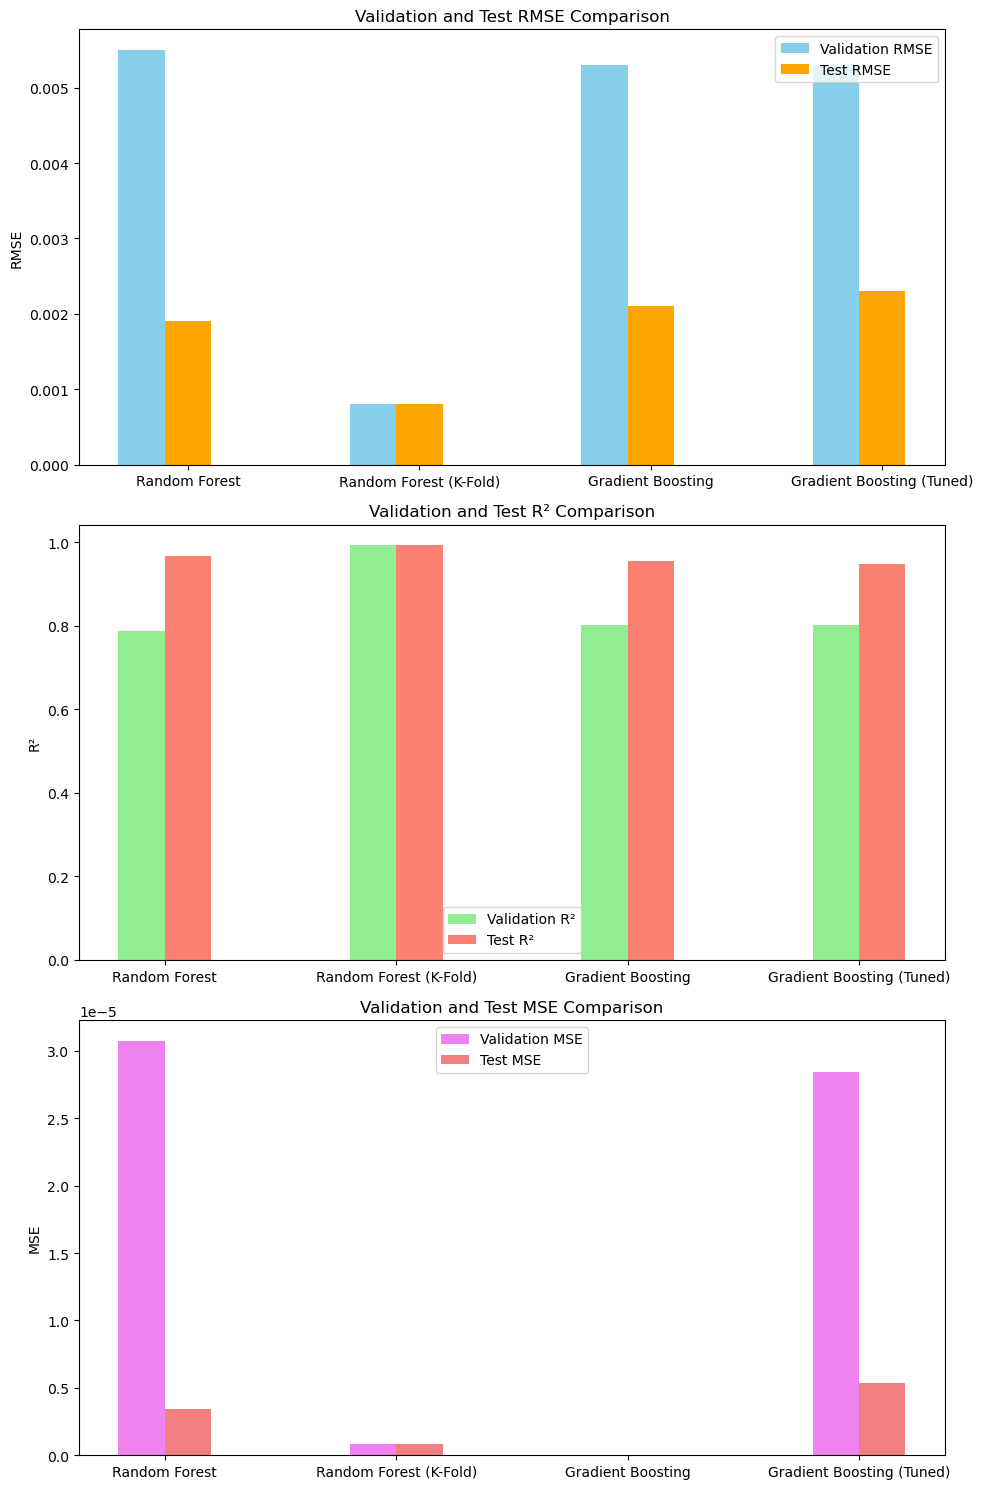

In [363]:
import matplotlib.pyplot as plt

model_results = {
    'Model': ['Random Forest', 'Random Forest (K-Fold)', 'Gradient Boosting', 'Gradient Boosting (Tuned)'],
    'Validation MSE': [3.0748e-05, 8.0096e-07, 0.0000, 2.8451e-05],
    'Validation RMSE': [0.0055, 0.0008, 0.0053, 0.0053],
    'Validation R²': [0.7863, 0.9922, 0.8027, 0.8022],
    'Test MSE': [3.4386e-06, 8.0096e-07, 0.0000, 5.3438e-06],
    'Test RMSE': [0.0019, 0.0008, 0.0021, 0.0023],
    'Test R²': [0.9670, 0.9922, 0.9557, 0.9487]
}

df_results = pd.DataFrame(model_results)


fig, ax = plt.subplots(3, 1, figsize=(10, 15))
x = np.arange(len(df_results['Model']))
width = 0.2

# Plot Validation RMSE
ax[0].bar(x - width, df_results['Validation RMSE'], width, label='Validation RMSE', color='skyblue')
ax[0].bar(x, df_results['Test RMSE'], width, label='Test RMSE', color='orange')
ax[0].set_xticks(x)
ax[0].set_xticklabels(df_results['Model'])
ax[0].set_ylabel('RMSE')
ax[0].set_title('Validation and Test RMSE Comparison')
ax[0].legend()

# Plot Validation R²
ax[1].bar(x - width / 2, df_results['Validation R²'], width, label='Validation R²', color='lightgreen')
ax[1].bar(x + width / 2, df_results['Test R²'], width, label='Test R²', color='salmon')
ax[1].set_xticks(x)
ax[1].set_xticklabels(df_results['Model'])
ax[1].set_ylabel('R²')
ax[1].set_title('Validation and Test R² Comparison')
ax[1].legend()

# Plot Validation MSE
ax[2].bar(x - width / 2, df_results['Validation MSE'], width, label='Validation MSE', color='violet')
ax[2].bar(x + width / 2, df_results['Test MSE'], width, label='Test MSE', color='lightcoral')
ax[2].set_xticks(x)
ax[2].set_xticklabels(df_results['Model'])
ax[2].set_ylabel('MSE')
ax[2].set_title('Validation and Test MSE Comparison')
ax[2].legend()

plt.tight_layout()
plt.show()


In [365]:

model_results = {
    'Model': ['Random Forest', 'Random Forest (K-Fold)', 'Gradient Boosting', 'Gradient Boosting (Tuned)'],
    'Validation MSE': [3.0748e-05, 8.0096e-07, 0.0000, 2.8451e-05],
    'Validation RMSE': [0.0055, 0.0008, 0.0053, 0.0053],
    'Validation R²': [0.7863, 0.9922, 0.8027, 0.8022],
    'Test MSE': [3.4386e-06, 8.0096e-07, 0.0000, 5.3438e-06],
    'Test RMSE': [0.0019, 0.0008, 0.0021, 0.0023],
    'Test R²': [0.9670, 0.9922, 0.9557, 0.9487]
}

df_results = pd.DataFrame(model_results)

print(df_results)

df_results.to_csv('model_comparison_results.csv', index=False)


                       Model  Validation MSE  Validation RMSE  Validation R²      Test MSE  Test RMSE  Test R²
0              Random Forest    3.074800e-05           0.0055         0.7863  3.438600e-06     0.0019   0.9670
1     Random Forest (K-Fold)    8.009600e-07           0.0008         0.9922  8.009600e-07     0.0008   0.9922
2          Gradient Boosting    0.000000e+00           0.0053         0.8027  0.000000e+00     0.0021   0.9557
3  Gradient Boosting (Tuned)    2.845100e-05           0.0053         0.8022  5.343800e-06     0.0023   0.9487


## Time Series Analysis
I'm curious if there was any correlation to the number of accounts created on certain days/times.

In [377]:
#Extracting the 'created_at' column and creating a new df with all time elements

df_time_series = df[['created_at']].copy()  # Create a new DataFrame with just 'created_at'

df_time_series['created_at'] = pd.to_datetime(df_time_series['created_at'], format='%m/%d/%y %H:%M')

df_time_series['date'] = df_time_series['created_at'].dt.date
df_time_series['time'] = df_time_series['created_at'].dt.time

df_time_series['day_of_week'] = df_time_series['created_at'].dt.day_name()

df_time_series['hour'] = df_time_series['created_at'].dt.hour

def time_of_day(hour):
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_time_series['time_of_day'] = df_time_series['hour'].apply(time_of_day)

df_time_series.drop(columns=['created_at', 'hour'], inplace=True)

df_time_series.head()

date      time day_of_week     time_of_day
0  2024-10-29  21:27:00     Tuesday           Night
1  2024-10-29  21:03:00     Tuesday           Night
2  2024-10-29  19:56:00     Tuesday         Evening
3  2024-10-29  18:37:00     Tuesday         Evening
4  2024-10-29  16:44:00     Tuesday  Late Afternoon

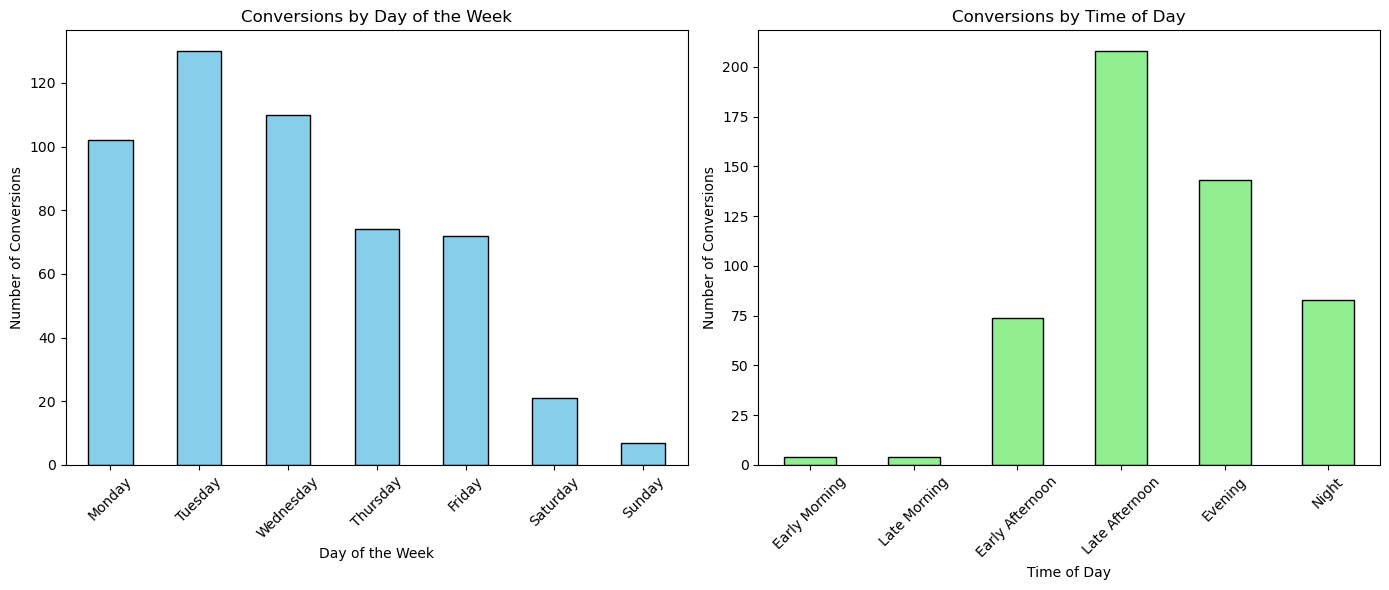

In [375]:
import matplotlib.pyplot as plt


df_time_series['conversion'] = 1

day_of_week_summary = df_time_series.groupby('day_of_week')['conversion'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

time_of_day_summary = df_time_series.groupby('time_of_day')['conversion'].sum().reindex(
    ['Early Morning', 'Late Morning', 'Early Afternoon', 'Late Afternoon', 'Evening', 'Night']
)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
day_of_week_summary.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
time_of_day_summary.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Conversions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


month
7      57
8     149
9     136
10    174
Name: conversion, dtype: int64


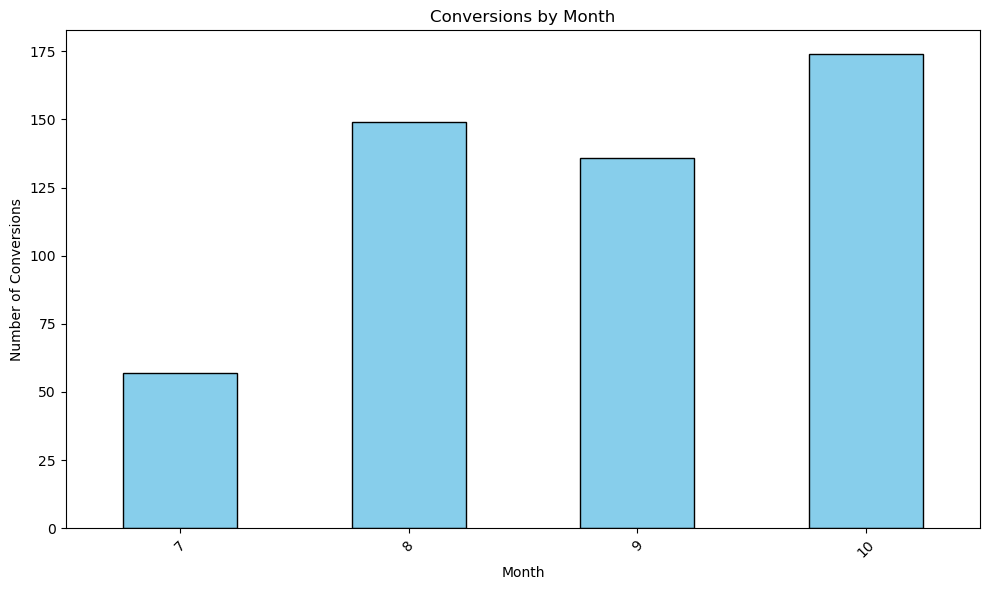

In [414]:
#Grouping totals by month
df_time_series = df[['created_at']].copy() 
df_time_series['created_at'] = pd.to_datetime(df_time_series['created_at'], format='%m/%d/%y %H:%M')

df_time_series['date'] = df_time_series['created_at'].dt.date
df_time_series['time'] = df_time_series['created_at'].dt.time
df_time_series['day_of_week'] = df_time_series['created_at'].dt.day_name()
df_time_series['hour'] = df_time_series['created_at'].dt.hour

def time_of_day(hour):
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_time_series['time_of_day'] = df_time_series['hour'].apply(time_of_day)

df_time_series.drop(columns=['hour'], inplace=True)

df_time_series['conversion'] = 1
df_time_series['month'] = df_time_series['created_at'].dt.month

monthly_summary = df_time_series.groupby('month')['conversion'].sum()

print(monthly_summary)

plt.figure(figsize=(10, 6))
monthly_summary.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Conversions by Month')
plt.xlabel('Month')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


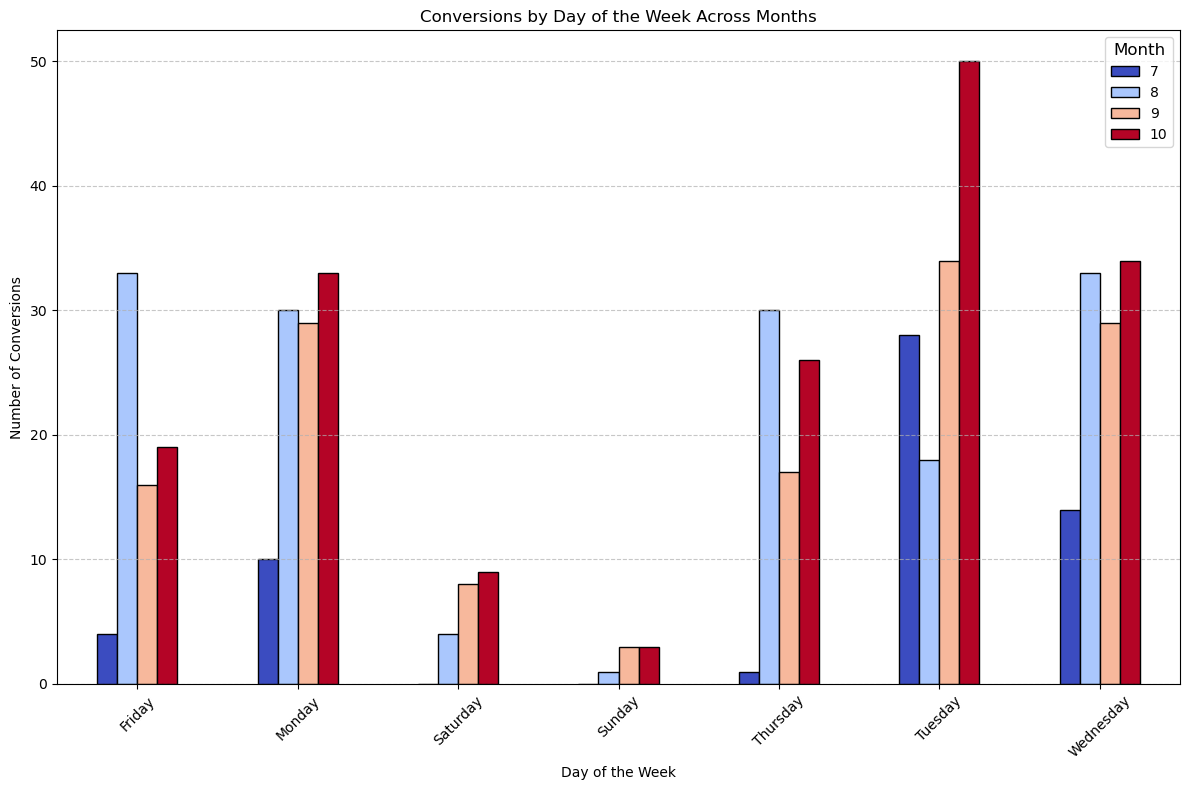

In [415]:
#looking at the trends on a weekly basis


df_time_series['month'] = pd.to_datetime(df_time_series['date']).dt.month

monthly_weekly_conversions = df_time_series.groupby(['month', 'day_of_week']).size().reset_index(name='conversion_count')

pivot_data = monthly_weekly_conversions.pivot(index='day_of_week', columns='month', values='conversion_count')

pivot_data.plot(kind='bar', figsize=(12, 8), cmap='coolwarm', edgecolor='black')

plt.title('Conversions by Day of the Week Across Months')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Conversions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Month', title_fontsize='12', fontsize='10')

plt.tight_layout()
plt.show()



### Time Series Results

- High Conversion Days Were Tue and Wed: Conversions peaked consistently on Tuesdays and Wednesdays across all months, indicating a strong mid-week activity. Sales efforts focused on these days could yield the highest results.

- Strongest Month was Oct: Conversion counts showed an increase from sept to oct after a drop from aug to sept. This suggests that marketing or other initiatives we had were gaining traction.

- Weekend Dip: Conversions were lowest on weekends, with Saturdays consistently underperforming.

- Peak Conversion Times: Conversions were significantly higher during the late afternoon (3 PM - 6 PM) and evening hours (6 PM - 9 PM). Customers seem to be more responsive towards the end of the day, possibly after their work hours. Targeting outreach during these times could improve engagement and conversions.